In [145]:
import os
import json
import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import display
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from kaggle.api.kaggle_api_extended import KaggleApi #sometimes throws errors and has to be rerun for some reason

In [59]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.clear_session()

In [60]:
api = KaggleApi()
folder_path = 'Dataset'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    api.dataset_download_files('wanderdust/coin-images', path=folder_path, unzip=True)
else:
    print('Dataset already downloaded')

Dataset already downloaded


In [61]:
num_classes = 211
input_size = 164

In [123]:
with open('Dataset/cat_to_name.json','r') as f:
    coin_data = json.load(f)


{'1': '1 Cent,Australian dollar,australia', '2': '2 Cents,Australian dollar,australia', '3': '5 Cents,Australian dollar,australia', '4': '10 Cents,Australian dollar,australia', '5': '20 Cents,Australian dollar,australia', '6': '50 Cents,Australian dollar,australia', '7': '1 Dollar,Australian dollar,australia', '8': '2 Dollars,Australian dollar,australia', '9': '1 Centavo,Brazilian Real,brazil', '10': '5 Centavos,Brazilian Real,brazil', '11': '10 Centavos,Brazilian Real,brazil', '12': '25 Centavos,Brazilian Real,brazil', '13': '1 Real,Brazilian Real,brazil', '14': '1 Penny,British Pound,united_kingdom', '15': '2 Pence,British Pound,united_kingdom', '16': '5 Pence,British Pound,united_kingdom', '17': '10 Pence,British Pound,united_kingdom', '18': '20 Pence,British Pound,united_kingdom', '19': '50 Pence,British Pound,united_kingdom', '20': '1 Pound,British Pound,united_kingdom', '21': '2 Pounds,British Pound,united_kingdom', '22': '1 Cent,Canadian Dollar,canada', '23': '5 Cents,Canadian D

In [63]:
image_paths = {'train':[],'validation':[],'test':[]}
labels = {'train':[],'validation':[],'test':[]}
paths = {'train':'Dataset/coins/data/train',
         'validation':'Dataset/coins/data/validation/',
         'test': 'Dataset/coins/data/test/'
         }
for k in ['train', 'validation', 'test']:
    for parent_file_name in os.listdir(paths[k]):
        for file_name in os.listdir(os.path.join(paths[k],parent_file_name)):
            if file_name.endswith(('.jpg','.png','.jpeg')):
                image_paths[k].append(os.path.join(paths[k],parent_file_name,file_name))
                labels[k].append(parent_file_name)

In [102]:
def image_preprocessing(image_path, label = None,num_classes=None,augment = False):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, np.float32) 
    image = tf.image.resize(image, [input_size, input_size])
    if label:
        label = tf.one_hot(int(label),num_classes)
    
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
          
    return image, label  

In [ ]:
dataset = {}


for k in image_paths:

    image_list = image_paths[k]
    label_list = labels[k]
    
    

    tf_dataset = tf.data.Dataset.from_tensor_slices((image_list, label_list))
    
    tf_dataset = tf_dataset.map(lambda image_path, label: image_preprocessing(image_path, label, num_classes), 
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if k == 'train':  
        
        tf_augmented_dataset = tf.data.Dataset.from_tensor_slices((image_list, label_list))
        tf_augmented_dataset = tf_augmented_dataset.map(
            lambda image_path, label: image_preprocessing(image_path, label, num_classes, augment=True),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        tf_dataset = tf_dataset.concatenate(tf_augmented_dataset)

    tf_dataset = tf_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    
    dataset[k] = tf_dataset


In [ ]:
def residual_block(x, filters, strides=1, kernel_size=(3,3)):
  
    shortcut = x

    x = Conv2D(filters, kernel_size=(kernel_size), strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization(axis=-1)(x)
    x = LeakyReLU()(x)

    x = Conv2D(filters, kernel_size=(kernel_size), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization(axis=-1)(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization(axis=-1)(shortcut)

    x = Add()([x, shortcut])

    x = LeakyReLU()(x)

    return x

def build_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', use_bias=False)(input_layer)
    x = BatchNormalization(axis=-1)(x)
    x = LeakyReLU()(x)
    
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    x = Dropout(0.2)(x)


    for _ in range(3):
        x = residual_block(x, 64)


    x = residual_block(x, 128, strides=2)  
    for _ in range(3):
        x = residual_block(x, 128)


    x = residual_block(x, 256, strides=2)  
    for _ in range(5):
        x = residual_block(x, 256)

  
    x = residual_block(x, 512, strides=2)  
    for _ in range(2):
        x = residual_block(x, 512)

  
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.2)(x)


    x = Flatten()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

model = build_model((input_size,input_size,3), num_classes)
model.compile(optimizer='sgd', metrics=['accuracy'], loss='categorical_crossentropy')

model.fit(dataset['train'], validation_data=(dataset['validation']),batch_size=32,epochs=64)

Epoch 1/64
401/401 [==============================] - 83s 196ms/step - loss: 4.5637 - accuracy: 0.0996 - val_loss: 5.5369 - val_accuracy: 0.0450
Epoch 2/64
401/401 [==============================] - 70s 169ms/step - loss: 3.5330 - accuracy: 0.2478 - val_loss: 4.2910 - val_accuracy: 0.1896
Epoch 3/64
401/401 [==============================] - 70s 169ms/step - loss: 2.6844 - accuracy: 0.4082 - val_loss: 4.0905 - val_accuracy: 0.2287
Epoch 4/64
401/401 [==============================] - 70s 170ms/step - loss: 2.0170 - accuracy: 0.5437 - val_loss: 3.0901 - val_accuracy: 0.3578
Epoch 5/64
401/401 [==============================] - 70s 169ms/step - loss: 1.5581 - accuracy: 0.6401 - val_loss: 2.4658 - val_accuracy: 0.4775
Epoch 6/64
401/401 [==============================] - 70s 170ms/step - loss: 1.2081 - accuracy: 0.7168 - val_loss: 2.1080 - val_accuracy: 0.5344
Epoch 7/64
401/401 [==============================] - 71s 172ms/step - loss: 0.9386 - accuracy: 0.7768 - val_loss: 2.2346 - val_ac

In [148]:
loss, accuracy = model.evaluate(dataset['test'])
print(f'Testing results:\n Loss: {loss}\n Accuracy: {accuracy}')
model.save('coin_man')

27/27 [==============================] - 4s 52ms/step - loss: 1.1030 - accuracy: 0.7986
Testing results:
 Loss: 1.102992296218872
 Accuracy: 0.7985782027244568


INFO:tensorflow:Assets written to: coin_man\assets


INFO:tensorflow:Assets written to: coin_man\assets


In [149]:
model = load_model('coin_man')

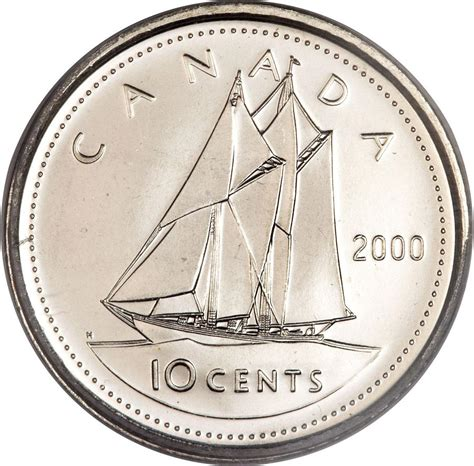

(164, 164, 3)
1/1 [==============================] - 1s 519ms/step
Model prediction: 10 Cents,Canadian Dollar,canada , Actual value: 10 Cents,Canadian Dollar,canada


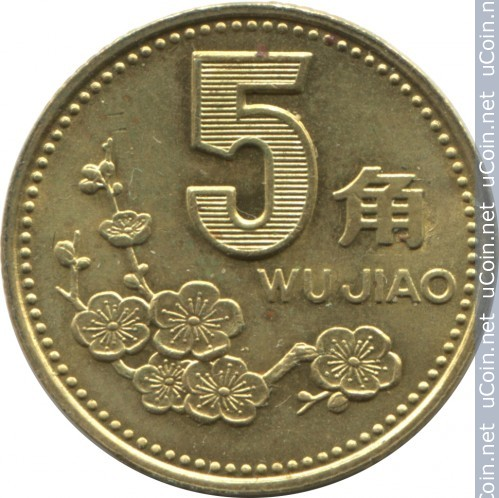

(164, 164, 3)
1/1 [==============================] - 0s 36ms/step
Model prediction: 5 Jiao,Chinese Yuan Renminbi,china , Actual value: 5 Jiao,Chinese Yuan Renminbi,china


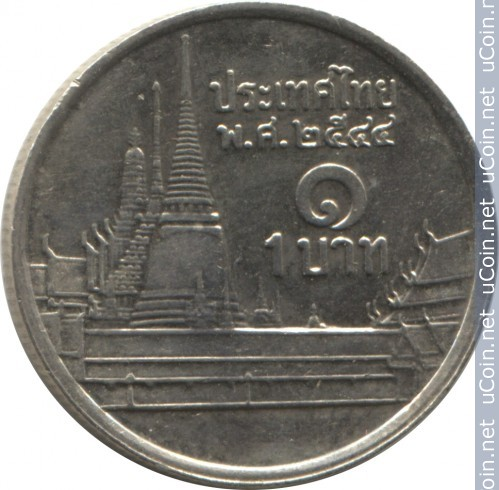

(164, 164, 3)
1/1 [==============================] - 0s 27ms/step
Model prediction: 1 Baht,Thai Baht,thailand , Actual value: 1 Baht,Thai Baht,thailand


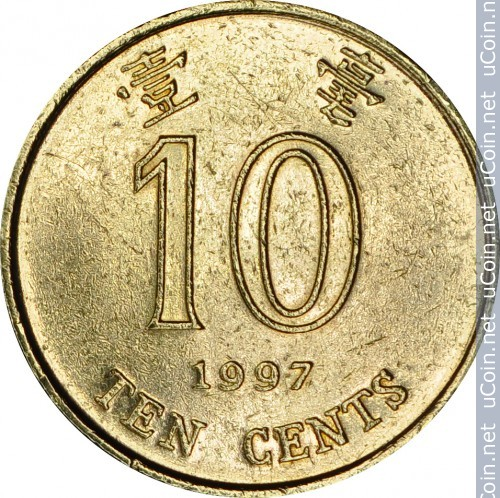

(164, 164, 3)
1/1 [==============================] - 0s 49ms/step
Model prediction: 10 Cents,Hong Kong dollar,hong_kong , Actual value: 10 Cents,Hong Kong dollar,hong_kong


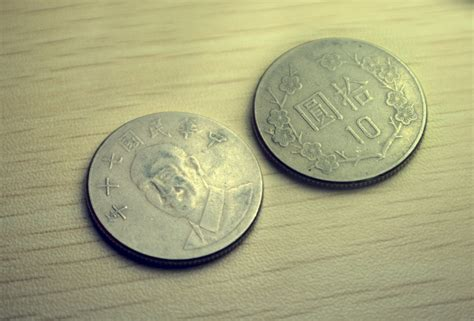

(164, 164, 3)
1/1 [==============================] - 0s 26ms/step
Model prediction: 5 Dollars,taiwan Dollar,taiwan , Actual value: 10 Dollars,taiwan Dollar,taiwan


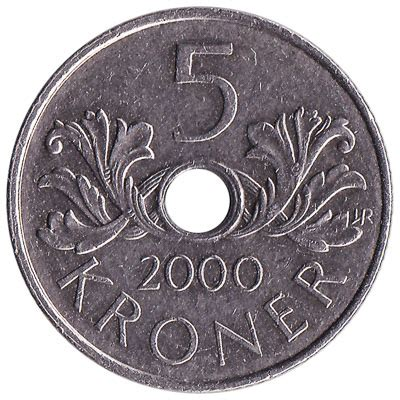

(164, 164, 3)
1/1 [==============================] - 0s 30ms/step
Model prediction: 10 Cents,Singapore Dollar,singapore , Actual value: 5 Kroner,Norwegian Krone,norway


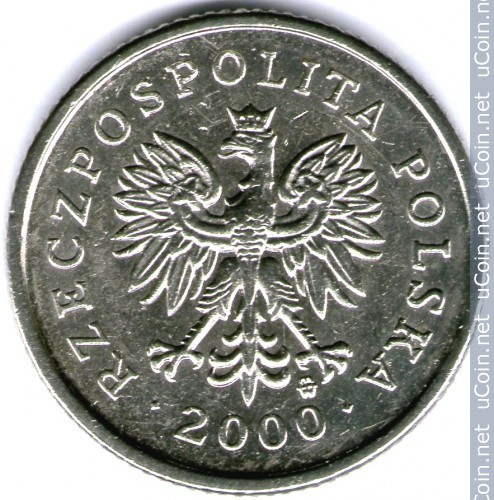

(164, 164, 3)
1/1 [==============================] - 0s 35ms/step
Model prediction: 10 Groszy,Polish Zloty,poland , Actual value: 20 Groszy,Polish Zloty,poland


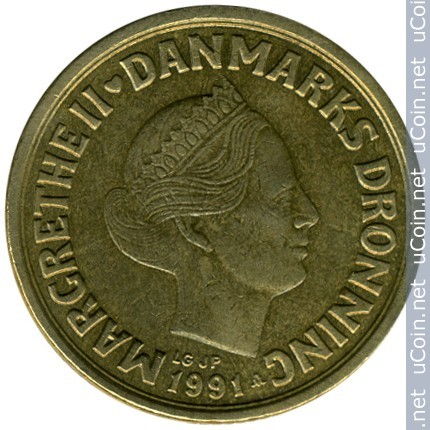

(164, 164, 3)
1/1 [==============================] - 0s 28ms/step
Model prediction: 20 Kroner,Danish Krone,denmark , Actual value: 20 Kroner,Danish Krone,denmark


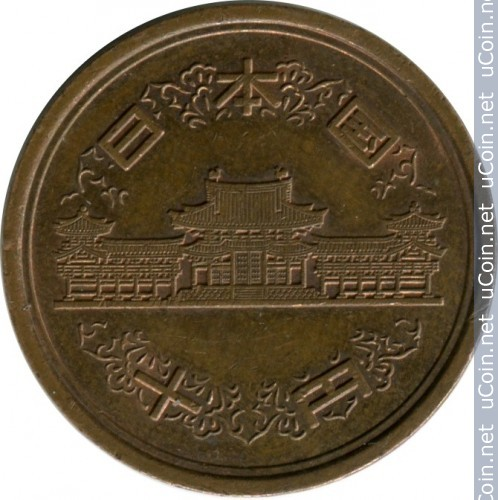

(164, 164, 3)
1/1 [==============================] - 0s 45ms/step
Model prediction: 10 Yen,Japanese Yen,japan , Actual value: 10 Yen,Japanese Yen,japan


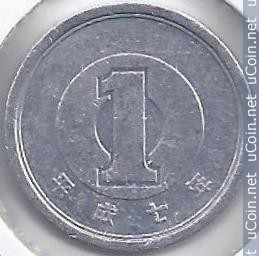

(164, 164, 3)
1/1 [==============================] - 0s 30ms/step
Model prediction: 1 Yen,Japanese Yen,japan , Actual value: 1 Yen,Japanese Yen,japan


In [150]:
for i in range(10):
    index = np.random.randint(0,len(image_paths['test']))
    test_case = image_paths['test'][index]
    image = Image.open(test_case)
    display(image)
    test_case  = image_preprocessing(test_case)[0]
    print(test_case.shape)
    test_case = np.expand_dims(test_case, axis=0)
    pred = model.predict(test_case)
    predicted_class = np.argmax(pred, axis=-1)[0]
    print(f"Model prediction: {coin_data[str(predicted_class)]} , Actual value: {coin_data[labels['test'][index]]}")
